In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

In [3]:
# Define dataset path
train_dir = "/content/drive/MyDrive/Week5/FruitinAmazon/train"
test_dir ="/content/drive/MyDrive/Week5/FruitinAmazon/test"


In [4]:
import os
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [5]:

corrupted_images = []  # List to store corrupted image paths

# Loop through each class folder and check for corrupted images
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a valid directory
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)

# Print results
if corrupted_images:
    print("\nCorrupted Images Found:")
    for img in corrupted_images:
        print(img)
else:
    print("\nNo corrupted images found.")



No corrupted images found.


In [6]:
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(images)

print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)



Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


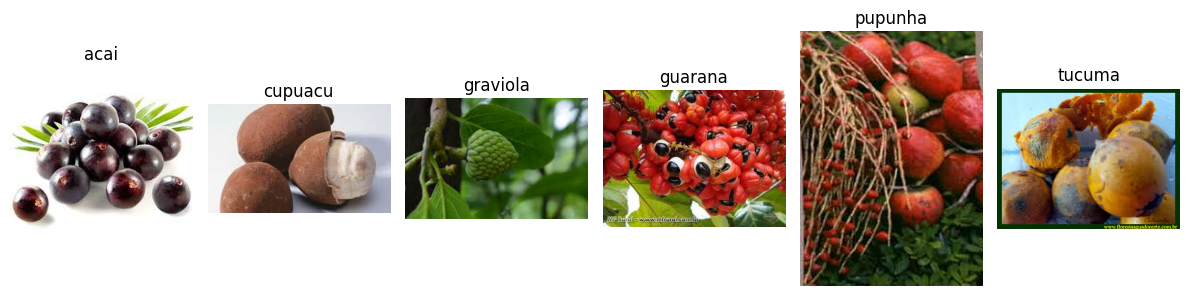

In [7]:


selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            selected_img = os.path.join(class_path, random.choice(images))
            selected_images.append(selected_img)
            selected_labels.append(class_name)

num_classes = len(selected_images)
fig, axes = plt.subplots(1,num_classes, figsize=(12,6))

if num_classes == 1:
    axes = [axes]

for ax, img_path, label in zip(axes, selected_images, selected_labels):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [8]:
# Define image size and batch size
img_height = 224
img_width = 224
batch_size = 64


# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical',
    seed=123
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Verify class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")




Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Number of classes: 6


In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [10]:

from tensorflow.keras.layers import LeakyReLU

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    for filters in [32, 64, 128, 256]:
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.15)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

model = make_model(input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,0

 Total params: 491,334 (1.87 MB)

 Trainable params: 489,606 (1.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [11]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
# Callbacks
checkpoint = ModelCheckpoint('best_model_task1.h5', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train
history = model.fit(
    train_ds,
    epochs=250,
    batch_size = batch_size,
    validation_data=test_ds,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1458 - loss: 2.5631  

2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 16s/step - accuracy: 0.1528 - loss: 2.5317 - val_accuracy: 0.1667 - val_loss: 1.7896
Epoch 2/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 0.3138 - loss: 1.6466 - val_accuracy: 0.1667 - val_loss: 1.7859
Epoch 3/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.3664 - loss: 1.7899 - val_accuracy: 0.1667 - val_loss: 1.7810
Epoch 4/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.4177 - loss: 1.5147 - val_accuracy: 0.1667 - val_loss: 1.7751
Epoch 5/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4821 - loss: 1.3633  

2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.4918 - loss: 1.3424 - val_accuracy: 0.2000 - val_loss: 1.7698
Epoch 6/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.5557 - loss: 1.2707 - val_accuracy: 0.2000 - val_loss: 1.7664
Epoch 7/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.5148 - loss: 1.2136 - val_accuracy: 0.2000 - val_loss: 1.7618
Epoch 8/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5189 - loss: 1.2222  

2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.5200 - loss: 1.2176 - val_accuracy: 0.2667 - val_loss: 1.7576
Epoch 9/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 11s/step - accuracy: 0.5905 - loss: 1.0274 - val_accuracy: 0.2333 - val_loss: 1.7627
Epoch 10/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 8s/step - accuracy: 0.6009 - loss: 1.0377 - val_accuracy: 0.1667 - val_loss: 1.7744
Epoch 11/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.6610 - loss: 1.0010 - val_accuracy: 0.1667 - val_loss: 1.7906
Epoch 12/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 8s/step - accuracy: 0.5927 - loss: 1.0584 - val_accuracy: 0.1667 - val_loss: 1.8051
Epoch 13/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 9s/step - accuracy: 0.5949 - loss: 0.9711 - val_accuracy: 0.1667 - val_loss: 1.8161
Epoch 14/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step - accuracy: 0.5370 - loss: 1.0147 - val_accuracy: 0.1667 - val_loss: 1.8238


In [13]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2667 - loss: 1.7576
Test accuracy: 0.2667
Test loss: 1.7576


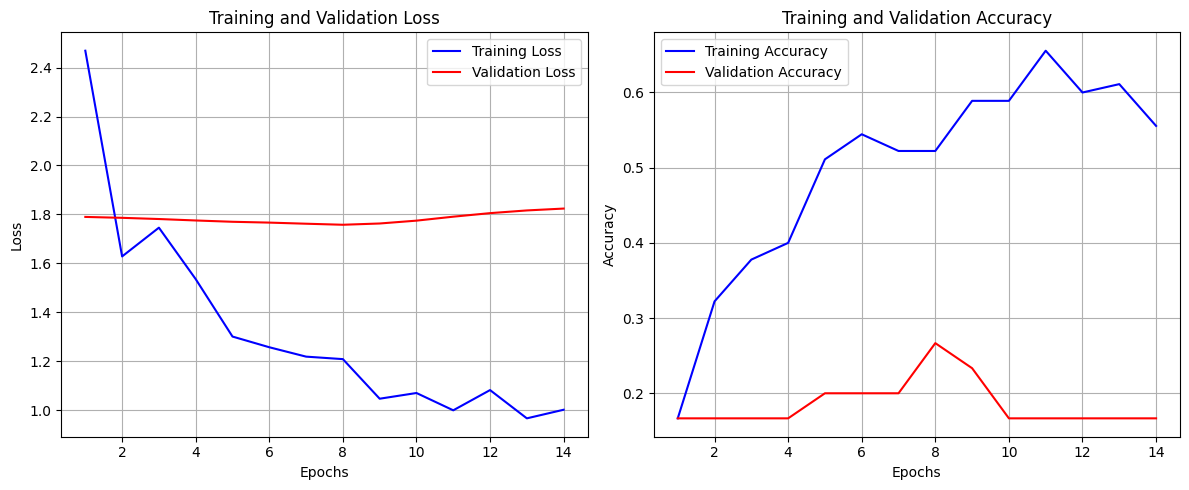

In [14]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [15]:
model.save('AayushBahadurShahi_w6_task1.h5')
print("Model saved as 'AayushBahadurShahi_w6_task1.h5'")

Model saved as 'AayushBahadurShahi_w6_task1.h5'


Task2

In [16]:

loaded_model = tf.keras.models.load_model('AayushBahadurShahi_w6_task1.h5')
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {loaded_test_acc:.4f}")
print(f"Loaded model test loss: {loaded_test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2667 - loss: 1.7576
Loaded model test accuracy: 0.2667
Loaded model test loss: 1.7576


In [18]:
loaded_model = keras.models.load_model('AayushBahadurShahi_w6_task1.h5')
print("Model loaded for predictions")

# Collect all test images and labels
all_images = []
all_labels = []
for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Concatenate batches into single arrays
test_images = np.concatenate(all_images, axis=0)  # Shape: (30, 128, 128, 3)
test_labels_onehot = np.concatenate(all_labels, axis=0)  # Shape: (30, 6)

# Make predictions
predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)


print(f"Class names: {class_names}")

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

Model loaded for predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Classification Report:
               precision    recall  f1-score   support

        acai       0.00      0.00      0.00         5
     cupuacu       0.18      0.80      0.30         5
    graviola       0.50      0.80      0.62         5
     guarana       0.00      0.00      0.00         5
     pupunha       0.00      0.00      0.00         5
      tucuma       0.00      0.00      0.00         5

    accuracy                           0.27        30
   macro avg       0.11      0.27      0.15        30
weighted avg       0.11      0.27      0.15        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model_vgg = keras.Model(inputs=base_model.input, outputs=outputs)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history_vgg = model_vgg.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    callbacks=[ModelCheckpoint('best_model_task2.h5', monitor='val_accuracy', save_best_only=True),
               EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.2038 - loss: 6.1386 

2/2 ━━━━━━━━━━━━━━━━━━━━ 75s 35s/step - accuracy: 0.1988 - loss: 6.2359 - val_accuracy: 0.3667 - val_loss: 8.8094
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5333 - loss: 7.2400 

2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 35s/step - accuracy: 0.5444 - loss: 7.0713 - val_accuracy: 0.5000 - val_loss: 7.8632
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6370 - loss: 4.8102 

2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 31s/step - accuracy: 0.6358 - loss: 4.7409 - val_accuracy: 0.6000 - val_loss: 4.0997
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8017 - loss: 0.9631 

2/2 ━━━━━━━━━━━━━━━━━━━━ 69s 35s/step - accuracy: 0.8086 - loss: 0.9318 - val_accuracy: 0.7000 - val_loss: 1.9152
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 81s 35s/step - accuracy: 0.9451 - loss: 0.2912 - val_accuracy: 0.5333 - val_loss: 4.0711
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 82s 35s/step - accuracy: 0.8042 - loss: 0.9899 - val_accuracy: 0.6000 - val_loss: 2.5000
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9543 - loss: 0.2298 

2/2 ━━━━━━━━━━━━━━━━━━━━ 83s 35s/step - accuracy: 0.9547 - loss: 0.2226 - val_accuracy: 0.7333 - val_loss: 1.6844
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 91s 55s/step - accuracy: 1.0000 - loss: 0.0183 - val_accuracy: 0.7000 - val_loss: 2.1728
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 71s 35s/step - accuracy: 0.9926 - loss: 0.0196 - val_accuracy: 0.6000 - val_loss: 2.8070
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 81s 35s/step - accuracy: 0.9926 - loss: 0.0300 - val_accuracy: 0.6667 - val_loss: 2.9923
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 82s 34s/step - accuracy: 0.9874 - loss: 0.0309 - val_accuracy: 0.6333 - val_loss: 3.0028
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 35s/step - accuracy: 0.9926 - loss: 0.0220 - val_accuracy: 0.6667 - val_loss: 2.9807
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 69s 35s/step - accuracy: 0.9874 - loss: 0.0145 - val_accuracy: 0.6667 - val_loss: 2.8504
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 82s 35s/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.6667 - val_loss: 2.6999
Epoch 

In [21]:
# Evaluate
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(test_ds)
print(f"Test accuracy for VGG16: {test_acc_vgg:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.7333 - loss: 1.6844
Test accuracy for VGG16: 0.7333


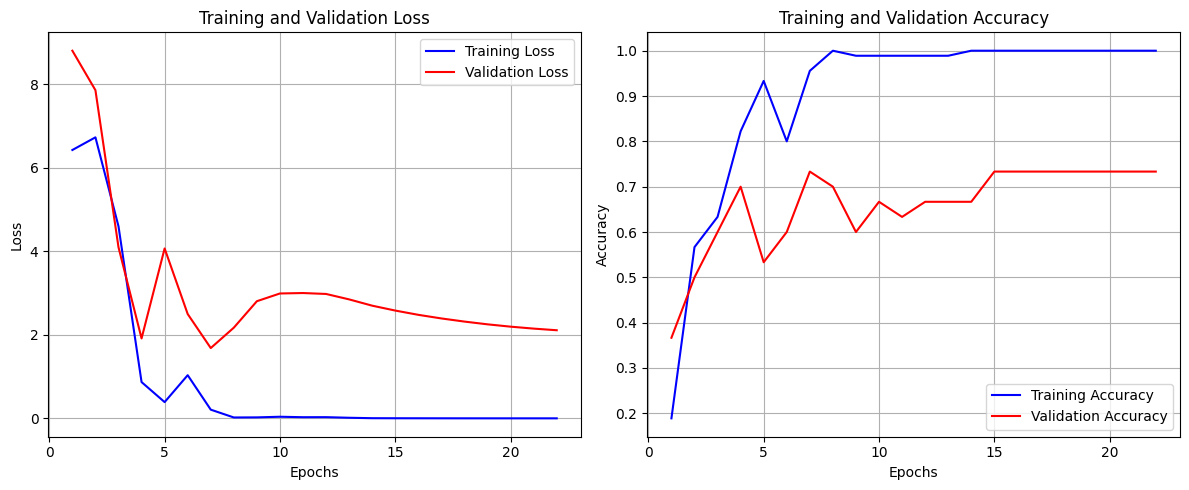

In [22]:
history_dict = history_vgg.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [23]:
model.save('AayushBahadurShahi_w6_task2.h5')
print("Model saved as 'AayushBahadurShahi_w6_task2.h5'")

Model saved as 'AayushBahadurShahi_w6_task2.h5'


In [24]:

predictions_vgg = model_vgg.predict(test_ds)
y_pred_vgg = np.argmax(predictions_vgg, axis=1)

# Classification Report
print("Classification Report for Task 2 (VGG16):")
print(classification_report(true_labels, y_pred_vgg, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
Classification Report for Task 2 (VGG16):
              precision    recall  f1-score   support

        acai       0.71      1.00      0.83         5
     cupuacu       1.00      0.40      0.57         5
    graviola       1.00      0.80      0.89         5
     guarana       1.00      1.00      1.00         5
     pupunha       0.60      0.60      0.60         5
      tucuma       0.43      0.60      0.50         5

    accuracy                           0.73        30
   macro avg       0.79      0.73      0.73        30
weighted avg       0.79      0.73      0.73        30

